# Linear Regression with a Real Dataset

This jupyter notebook uses a real dataset to predict the prices of houses in United States.

## Objectives:

  * Read a .csv file into a pandas DataFrame.
  * Examining the Dataset.
  * Experiment with different features in building a model.
  * Tune the model's hyperparameters.

## About the Dataset
  
The [dataset for this notebook](https://www2.cdc.gov/nceh/lead/census90/house11/download.htm) is based on 1990 census data from California.

## Import relevant modules

In [46]:
# Import relevant modules
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# The following lines adjust the granularity 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

### Loading the .csv file into a pandas DataFrame

The dataset has already been preprocessed. The following code cells imports the .csv file into a pandas DataFrame and scales the values in the label (`median_house_value`)

In [47]:
# Import the dataset
training_df = pd.read_csv(filepath_or_buffer="data/california_housing_train.csv")

training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0


In [48]:
# scaling the label (median_house_value)
training_df["median_house_value"] /= 1000.0 

Scaling `median_house_value` puts the value of each house in units of thousands. Scaling will keep loss values and learning rates in a friendlier range.  

Although scaling a label is usually not essential, scaling features in a multi-feature model usually is essential

## Examine the dataset

A large part of machine learning projects is getting to know your data. Pandas module provides a `describe` function that outputs the most common statistics about the dataset:

* `count`, which is the number of rows in that column.  

* `mean` and `std`, which contain the mean and standard deviation of the values in each column. 

* `min` and `max`, which contain the lowest and highest values in each column.


In [49]:
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


### Identify anomalies in the dataset

The maximum value (max) of several columns is very
high compared to the other quantities. For example,
example the total_rooms column.

Its better not to use total_rooms as a feature.




## Defining functions that build and train a model


  * `build_model(my_learning_rate)`, which builds a randomly-initialized model.
  * `train_model(model, feature, label, epochs)`, which trains the model from the feature and label.
  


In [50]:
    """ build the model """
def build_model(my_learning_rate):
  # most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

    
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))

  # compiling the model topography into code that TensorFlow can execute
  # configuring training to minimize the model's mean squared error. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model        


    """train the model"""
def train_model(model, df, feature, label, epochs, batch_size):
    
  # input feature and the label
  # The model will train for the specified number of epochs. 
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs)

  # gathering the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]


  epochs = history.epoch
  
  # isolating the error for each epoch
  hist = pd.DataFrame(history.history)

  # To track the progression of training we're going to take a snapshot
  # of the model's RMS error at each epoch 
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

## Defining plotting functions

The following matplotlib functions create the following plots:

*  a scatter plot of the feature vs. the label, and a line showing the output of the trained model
*  a loss curve


In [51]:
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against 200 random training examples."""

  plt.xlabel(feature)
  plt.ylabel(label)

  # creating a scatter plot from 200 random points of the dataset.
  random_examples = training_df.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # creating a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = 10000
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  plt.show()


def plot_the_loss_curve(epochs, rmse):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  

## Calling the model functions

An important part of machine learning is determining which features correlate with the label


In [52]:
import warnings
warnings.filterwarnings('ignore')  #to hide warnings

Epoch 1/30
567/567 [==============================] - 1s 947us/step - loss: 3529677.2500 - root_mean_squared_error: 1878.7435
Epoch 2/30
567/567 [==============================] - 1s 909us/step - loss: 27524.7539 - root_mean_squared_error: 165.9059
Epoch 3/30
567/567 [==============================] - 1s 886us/step - loss: 27014.3711 - root_mean_squared_error: 164.3605
Epoch 4/30
567/567 [==============================] - 1s 934us/step - loss: 26218.4570 - root_mean_squared_error: 161.9211
Epoch 5/30
567/567 [==============================] - 1s 889us/step - loss: 25543.3301 - root_mean_squared_error: 159.8228
Epoch 6/30
567/567 [==============================] - 1s 947us/step - loss: 24819.7148 - root_mean_squared_error: 157.5427
Epoch 7/30
567/567 [==============================] - 1s 978us/step - loss: 24267.9258 - root_mean_squared_error: 155.7817
Epoch 8/30
567/567 [==============================] - 1s 980us/step - loss: 23679.5566 - root_mean_squared_error: 153.8816
Epoch 9/30
56

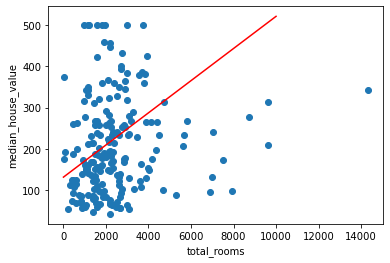

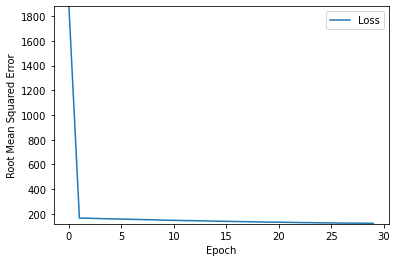

In [53]:
# Hyperparameters.
learning_rate = 0.01
epochs = 30
batch_size = 30


# Specifing the feature and the label
my_feature = "total_rooms"  
my_label="median_house_value" 

  
# discarding any pre-existing version of the model
my_model = None


# (y = mx + c) or (y = wx + b)
# where w, c are weight and bias
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,   
                                         my_feature, my_label,   
                                         epochs, batch_size)


print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

As you can tell, the trained model is not that good. This means that the trained model doesn't have much predictive power. The `total_rooms` is not a good feature.

In [54]:
""" Function to predict label Values """
def predict_house_values(n, feature, label):

  batch = training_df[feature][10000:10000 + n]
  predicted_values = my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("  value   value          value")
  print("          in thousand   in thousand")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (training_df[feature][10000 + i],
                                   training_df[label][10000 + i],
                                   predicted_values[i][0] ))

## Trying a different feature

The `total_rooms` feature had little predictive power. Maybe a different feature have greater predictive power like `total_bedrooms`.

When you change features, you might also need to tweak the hyperparameters.

Epoch 1/30
425/425 [==============================] - 0s 713us/step - loss: 76878.1484 - root_mean_squared_error: 277.2691
Epoch 2/30
425/425 [==============================] - 0s 701us/step - loss: 27727.2285 - root_mean_squared_error: 166.5150
Epoch 3/30
425/425 [==============================] - 0s 728us/step - loss: 26515.4141 - root_mean_squared_error: 162.8355
Epoch 4/30
425/425 [==============================] - 0s 753us/step - loss: 25533.2402 - root_mean_squared_error: 159.7912
Epoch 5/30
425/425 [==============================] - 0s 698us/step - loss: 24389.6875 - root_mean_squared_error: 156.1720
Epoch 6/30
425/425 [==============================] - 0s 707us/step - loss: 23358.0957 - root_mean_squared_error: 152.8336
Epoch 7/30
425/425 [==============================] - 0s 715us/step - loss: 22501.9922 - root_mean_squared_error: 150.0066
Epoch 8/30
425/425 [==============================] - 0s 711us/step - loss: 21630.3125 - root_mean_squared_error: 147.0725
Epoch 9/30
425/4

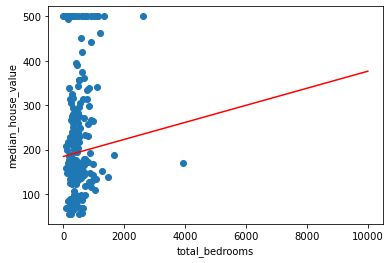

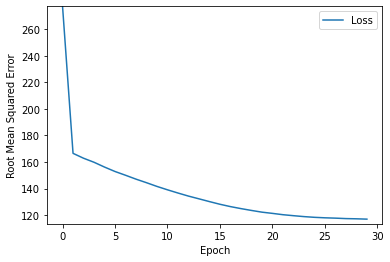

feature   label          predicted
  value   value          value
          in thousand   in thousand
--------------------------------------
  393     53             192
  618     92             196
  863     69             201
  471     62             194
  483     80             194
 1313    295             210
  441    500             193
  443    342             193
  282    118             190
  675    128             198
  363    187             192
  166     80             188
 1075    112             205
  741     95             199
  663     69             197


In [55]:
my_feature = "total_bedrooms"   # change feature here
            
learning_rate = 0.02
epochs = 30
batch_size = 40


""" train model """
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

""" plot """
plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)


""" predict label values """
predict_house_values(15, my_feature, my_label)



`total_bedrooms` also failed to produce better predictions

## A better way to find features whose values correlate with the label

So far, we've relied on trial-and-error to identify possible features for the model.  Let's rely on statistics. 
A **correlation matrix** indicates how each attribute's values relate to the other attribute's values. Correlation values have the following meanings:

  * `1.0`: perfect positive correlation; when one attribute rises, the other attribute rises.
  * `-1.0`: perfect negative correlation; when one attribute rises, the other attribute falls. 
  * `0.0`: no correlation; the two column's are not linearly related

In general, the higher the absolute value of a correlation value, the greater its predictive power. For example, a correlation value of -0.8 implies far more predictive power than a correlation of -0.2.

The following code cell generates the correlation matrix for attributes of the Dataset:



In [56]:
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0


 The `median_income` correlates 0.7 with the label 
 `(median_house_value)`, so `median_income` might be a 
 good feature. The other seven potential features
 all have a correlation close to 0. 

Epoch 1/24
567/567 [==============================] - 1s 962us/step - loss: 25392.8730 - root_mean_squared_error: 159.3514
Epoch 2/24
567/567 [==============================] - 1s 954us/step - loss: 7201.5532 - root_mean_squared_error: 84.8620
Epoch 3/24
567/567 [==============================] - 1s 1ms/step - loss: 7015.9248 - root_mean_squared_error: 83.7611
Epoch 4/24
567/567 [==============================] - 1s 936us/step - loss: 7015.8667 - root_mean_squared_error: 83.7608
Epoch 5/24
567/567 [==============================] - 1s 924us/step - loss: 7015.8408 - root_mean_squared_error: 83.7606
Epoch 6/24
567/567 [==============================] - 1s 933us/step - loss: 7014.0537 - root_mean_squared_error: 83.7499
Epoch 7/24
567/567 [==============================] - 1s 941us/step - loss: 7015.0347 - root_mean_squared_error: 83.7558
Epoch 8/24
567/567 [==============================] - 1s 923us/step - loss: 7015.2402 - root_mean_squared_error: 83.7570
Epoch 9/24
567/567 [============

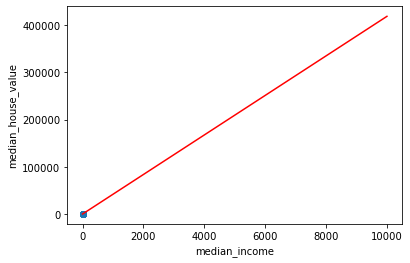

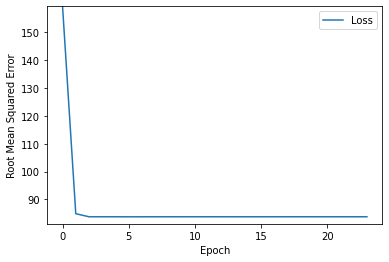

feature   label          predicted
  value   value          value
          in thousand   in thousand
--------------------------------------
    2     53             133
    4     92             210
    3     69             152
    2     62             131
    3     80             152
    2    295             146
   10    500             452
    5    342             257
    2    118             145
    4    128             219
    8    187             393
    3     80             161
    3    112             177
    4     95             219
    2     69             142


In [57]:
my_feature = "median_income"   
                   

learning_rate = 0.06
epochs = 24
batch_size = 30

my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(15, my_feature, my_label)

Based on the loss value, this feature produces a better model than the previous features. However, this feature still is not great at making predictions

Correlation matrices don't tell the entire story. Using `median_income` as a feature may raise some ethical issues